✅ 🔬 2. Concordance Breakdown Bar Plot

✔ What: For each modality, show % of:
	•	Exact matches
	•	Side matches
	•	Incorrect localizations

✔ Why: Shows diagnostic precision vs general localization
✔ How:
	•	Stacked bar plot or grouped bar plot (Exact, Side, Incorrect for each modality)


In [66]:
import pandas as pd 
import matplotlib.pyplot as plt
preop_imaging_df = pd.read_excel('../../Data/side_concordance_results.xlsx')

In [67]:
# Define modality
modalities = ['SPECT/CT', '4D CT Scan', 'Ultrasound', 'Sestamibi', 'MRI']

def check_concordance(row, modality_col):
    imaging = row[modality_col]
    surgical = row['Surgical_Findings']
    
    if pd.isnull(imaging) or pd.isnull(surgical):
        return 'Unknown'
    
    if imaging in ['No Scan', 'Non-localizing']:
        return 'Non-localizing'
    
    imaging_glands = [g.strip() for g in imaging.split(',')]
    surgical_glands = [g.strip() for g in surgical.split(',')]
    
    # Exact gland match
    if any(sg in imaging_glands for sg in surgical_glands):
        return 'Yes (Exact)'
    
    # Side match
    imaging_sides = ['Left' for ig in imaging_glands if 'Left' in ig] + \
                    ['Right' for ig in imaging_glands if 'Right' in ig]
    surgical_sides = ['Left' for sg in surgical_glands if 'Left' in sg] + \
                     ['Right' for sg in surgical_glands if 'Right' in sg]
    
    if any(side in surgical_sides for side in imaging_sides):
        return 'Yes (Side)'
    
    return 'Incorrect Localization'



In [68]:
for modality in modalities:
    concordance_col = modality + ' Calculated Concordance'
    preop_imaging_df[concordance_col] = preop_imaging_df.apply(
        lambda row: check_concordance(row, modality), axis=1
    )

# Initialize summary data list
summary_data = []

# Loop through modalities and collect counts + percentages
for modality in modalities:
    concordance_col = modality + ' Calculated Concordance'
    counts = preop_imaging_df[concordance_col].value_counts()
    total = counts.sum()
    
    for match_type, count in counts.items():
        pct = (count / total) * 100 if total > 0 else 0
        
        summary_data.append({
            'Modality': modality,
            'Concordance': match_type,
            'Count': count,
            'Percentage': pct
        })


In [69]:
# Convert to DataFrame
concordance_summary_df = pd.DataFrame(summary_data)

# Pivot for grouped bar plot
pivot_df = concordance_summary_df.pivot(index='Modality', columns='Concordance', values='Percentage').fillna(0)

# Reorder columns if desired
ordered_cols = ['Yes (Exact)', 'Yes (Side)', 'Incorrect Localization']
pivot_df = pivot_df.reindex(columns=ordered_cols).fillna(0)

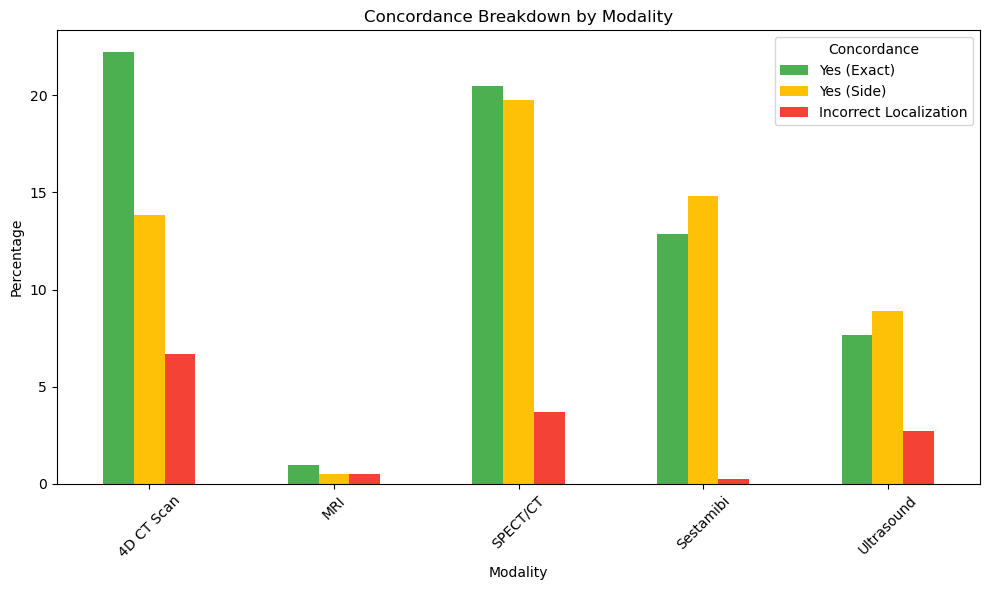

In [70]:
# Plot grouped bar plot
pivot_df.plot(
    kind='bar',
    figsize=(10,6),
    color=['#4CAF50', '#FFC107', '#F44336']  # green, yellow, red
)

plt.ylabel('Percentage')
plt.title('Concordance Breakdown by Modality')
plt.xticks(rotation=45)
plt.legend(title='Concordance')
plt.tight_layout()
plt.show()